In [4]:
rm(list = ls())
setwd('./')

library(ggplot2)
library(survival)
library(survminer)
library(cowplot)
library(ggthemes)
library(ggsci)
library(pheatmap)

In [23]:
get_color <- function(palette, n = 6,a = 0.7) {
  if(length(palette) > 1) return(palette)
  
  switch(tolower(palette), nature = {
    (ggsci::pal_npg("nrc",alpha = a))(n)
  }, jco = {
    (ggsci::pal_jco("default",alpha = a))(n)
  }, lancet = {
    # (ggsci::pal_lancet("lanonc",alpha = a))(n)
    h <- head(c("#42B540B2","#925E9FB2","#FDAF91B2"), n-2)
    c('#00468BB2',h,'#ED0000B2')
  }, color2 = {h <- head(c('#9ac9db','#f8ac8c','#ff8884'), n-2)
    c('#2878b5',h,'#c82423')
  }, color1 = {h <- head(c('#FFBE7A','#82B0D2','#BEB8DC','#E7DAD2'), n-2)
    c('#8ECFC9',h,'#FA7F6F')},
  RColorBrewer::brewer.pal(n, "Set1")
  )
}

customize_labels <- function(p, font.title = NULL,
                             font.subtitle = NULL, 
                             font.caption = NULL,
                             font.x = NULL, font.y = NULL, 
                             font.xtickslab = NULL, font.ytickslab = NULL){
  original.p <- p
  if(is.ggplot(original.p)) list.plots <- list(original.p)
  else if(is.list(original.p)) list.plots <- original.p
  else stop("Can't handle an object of class ", class (original.p))
  .set_font <- function(font){
    font <- ggpubr:::.parse_font(font)
    ggtext::element_markdown (size = font$size, face = font$face, colour = font$color)
  }
  for(i in 1:length(list.plots)){
    p <- list.plots[[i]]
    if(is.ggplot(p)){
      if (!is.null(font.title)) p <- p + theme(plot.title = .set_font(font.title))
      if (!is.null(font.subtitle)) p <- p + theme(plot.subtitle = .set_font(font.subtitle))
      if (!is.null(font.caption)) p <- p + theme(plot.caption = .set_font(font.caption))
      if (!is.null(font.x)) p <- p + theme(axis.title.x = .set_font(font.x))
      if (!is.null(font.y)) p <- p + theme(axis.title.y = .set_font(font.y))
      if (!is.null(font.xtickslab)) p <- p + theme(axis.text.x = .set_font(font.xtickslab))
      if (!is.null(font.ytickslab)) p <- p + theme(axis.text.y = .set_font(font.ytickslab))
      list.plots[[i]] <- p
    }
  }
  if(is.ggplot(original.p)) list.plots[[1]]
  else list.plots
}

surv_plot <- function(df, target,group,y_lab='OS',tt='AAAA123',
                      x_lim = c(0,10),x_break = 2,journal='lancet',
                      legend_size = 14,legend_pos = NULL) {

  temp_df <- df[c(target,group)]
  colnames(temp_df) <- c('time','event','risk')
  color <- get_color(journal,length(levels(temp_df$risk)))
  
  fit1 <- survfit(Surv(time, event)~risk, temp_df)
  fit2 <- survdiff(Surv(time, event)~risk, temp_df)
  fit3 <- summary(coxph(Surv(time, event)~risk, temp_df))
  hr_df <- data.frame(fit3$conf.int)
  hr_df$p <- fit3$coefficients[,5]
  p.val = surv_pvalue(fit1,temp_df)$pval
  
  HR_lb <- c("Low", "Medium", "High")
  p = paste0('Logrank-test: P',ifelse(scales::pvalue(p.val,accuracy = 0.0001)=='<0.0001',' < 0.0001',
                                      paste0(' = ',scales::pvalue(p.val,accuracy = 0.0001))))
  
  if (is.null(legend_pos)) {
    legend_pos = c(0.48,0.4+0.02*length(levels(temp_df$risk)))
  }
  os <- ggsurvplot(fit1, data = temp_df, risk.table = FALSE, ylim=c(0.4,1),
                   xlim = x_lim, break.x.by = x_break, #DACHS
                   censor.size=4.5,
                   palette = get_color(journal,length(levels(temp_df$risk))),
                   legend = legend_pos,
                   legend.labs = HR_lb,
                   legend.title= p,
                   ylab = y_lab, xlab = 'Years',title=tt,
                   font.legend=(size=legend_size), 
                   font.x = (size=0),
                   ggtheme=theme_few()+
                     theme(
                       plot.title =element_text(color="black", 
                                                size=15,
                                                face = 'bold',
                                                hjust = 0.5),
                       axis.text=element_text(size=12),
                       legend.background = element_rect(color = 'transparent',
                                                        fill='transparent'),
                       panel.border = element_rect(linewidth = 2, color = "black")
                       )
                   )

  os$plot <- customize_labels(
    os$plot,
    font.x = element_blank(),
    font.y = c(10)
  )
  os$plot <- os$plot + 
    theme(
      plot.margin = unit(c(2, 2, 2, 2), "points"))

  return(os)
}

In [7]:
GSE39582 <- read.table(file = "./data/processed/GSVA_GSE39582.csv",sep = ",") #566
GSE39582 <- subset(GSE39582,!is.na(GSE39582$rfsStat)) #557
GSE39582 <- subset(GSE39582,rfsMo > 0) #519
dim(GSE39582)

GSE14333 <- read.table(file = "./data/processed/GSVA_GSE14333.csv",sep = ",",header=1) #290
GSE14333 <- subset(GSE14333,!is.na(GSE14333$rfsStat)) #126
dim(GSE14333)

GSE33113 <- read.table(file = "./data/processed/GSVA_GSE33113.csv",sep = ",") #96
GSE33113 <- subset(GSE33113,!is.na(GSE33113$rfsStat)) #90
dim(GSE33113)

GSE37892 <- read.table(file = "./data/processed/GSVA_GSE37892.csv",sep = ",") #130
GSE37892 <- subset(GSE37892,!is.na(GSE37892$rfsStat)) #130
dim(GSE37892)

meta <- rbind(GSE14333,GSE33113,GSE37892)

table(meta$stage)
table(GSE39582$stage)

[1] 519  20

[1] 126  20

[1] 90 20

[1] 130  20


  1   2   3 
 24 220 102 


  1   2   3   4 
 40 249 200  30 

[1] 16.75

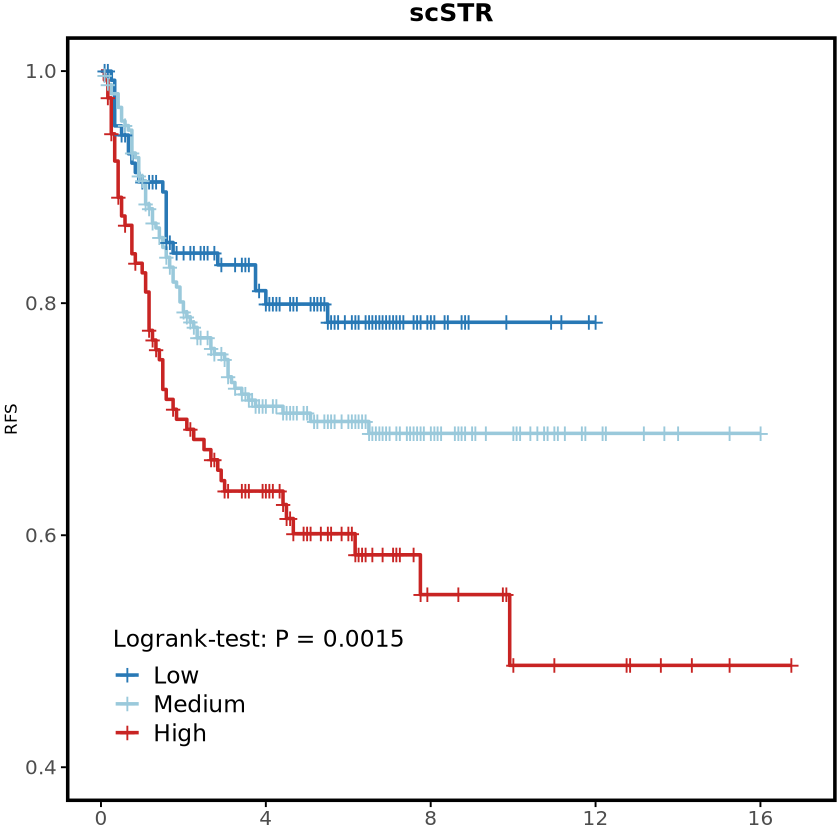

In [30]:
cutoff <- c(-Inf, quantile(GSE39582$scSTR, 0.25), quantile(GSE39582$scSTR, 0.75), Inf)

surv_data <- GSE39582
surv_data$group <- cut(surv_data$scSTR,
                        breaks = cutoff,
                        labels = c("Low", "Medium", "High"),
                        include.lowest = TRUE)
surv_data$rfsMo <- surv_data$rfsMo/12
max(surv_data$rfsMo)
fit <- survfit(Surv(rfsMo, rfsStat) ~ group, data = surv_data)
p1 <- surv_plot(surv_data,c('rfsMo', 'rfsStat'),'group',y_lab='RFS',journal='color2',
                x_lim = c(0,17),x_break=4,tt='scSTR',legend_pos=c(0.25,0.15))
p1


   Low Medium   High 
    89    179     78 

[1] 9.997222

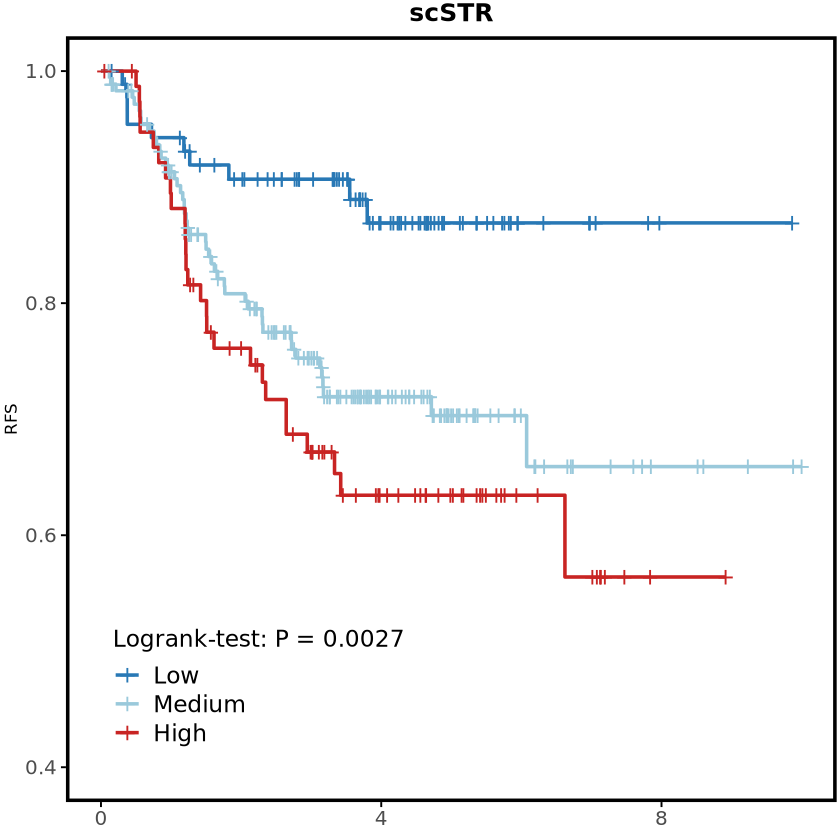

In [34]:
surv_data <- meta
surv_data$group <- cut(surv_data$scSTR,
                        breaks = cutoff,
                        labels = c("Low", "Medium", "High"),
                        include.lowest = TRUE)
table(surv_data$group)
surv_data$rfsMo <- surv_data$rfsMo/12
max(surv_data$rfsMo)
fit <- survfit(Surv(rfsMo, rfsStat) ~ group, data = surv_data)
p1 <- surv_plot(surv_data,c('rfsMo', 'rfsStat'),'group',y_lab='RFS',journal='color2',
                x_lim = c(0,10),x_break=4,tt='scSTR',legend_pos=c(0.25,0.15))
p1

In [37]:
sessionInfo()

R version 4.3.3 (2024-02-29)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Debian GNU/Linux 12 (bookworm)

Matrix products: default
BLAS/LAPACK: ./anaconda3/envs/scCRC/lib/libopenblasp-r0.3.24.so;  LAPACK version 3.11.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: Europe/Berlin
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] lubridate_1.9.3 forcats_1.0.0   stringr_1.5.0   purrr_1.0.2    
 [5] readr_2.1.4     tidyr_1.3.0     tibble_3.2.1    tidyverse_2.0.0
 [9] dplyr_1.1.3     pheatmap_1.0.12 ggsci_3.0.0     ggthemes_5.0.0 
[13] cowplot_1.1.1